In [17]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

CNN Model Implementation

In [20]:
# Path to the directory containing the images
data_dir = '/kaggle/input/diabetic-retinopathy-dataset'

# Create a list of all image file paths and corresponding labels
image_paths = []
labels = []

# Iterate through each class folder
for class_folder in os.listdir(data_dir):
    class_label = class_folder.split(':')[0].strip()  # Extract class label from folder name
    class_path = os.path.join(data_dir, class_folder)
    # Iterate through each image in the class folder
    for image_file in os.listdir(class_path):
        # Append the image path and label to the lists
        image_paths.append(os.path.join(class_path, image_file))
        labels.append(class_label)

# Define diagnosis mapping dictionaries
diagnosis_dict = {
    'Healthy': '0',
    'Mild DR': '1',
    'Moderate DR': '2',
    'Severe DR': '3',
    'Proliferate DR': '4',
}

# Create a DataFrame from the lists
df = pd.DataFrame({'image_path': image_paths, 'class_label': labels})

# Add the 'type' column based on the 'class_label' column
df['type'] = df['class_label'].map(diagnosis_dict)

# Display the DataFrame
print(df.head())

                                          image_path class_label type
0  /kaggle/input/diabetic-retinopathy-dataset/Sev...   Severe DR    3
1  /kaggle/input/diabetic-retinopathy-dataset/Sev...   Severe DR    3
2  /kaggle/input/diabetic-retinopathy-dataset/Sev...   Severe DR    3
3  /kaggle/input/diabetic-retinopathy-dataset/Sev...   Severe DR    3
4  /kaggle/input/diabetic-retinopathy-dataset/Sev...   Severe DR    3


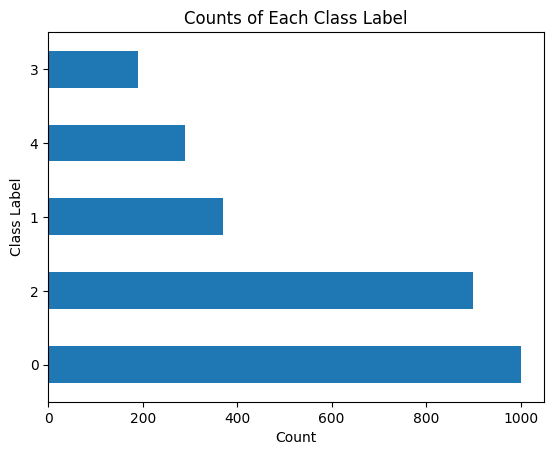

In [21]:
# Plot the counts of each class label
df['type'].value_counts().plot(kind='barh')

# Set plot labels and title
plt.xlabel('Count')
plt.ylabel('Class Label')
plt.title('Counts of Each Class Label')

# Show the plot
plt.show()

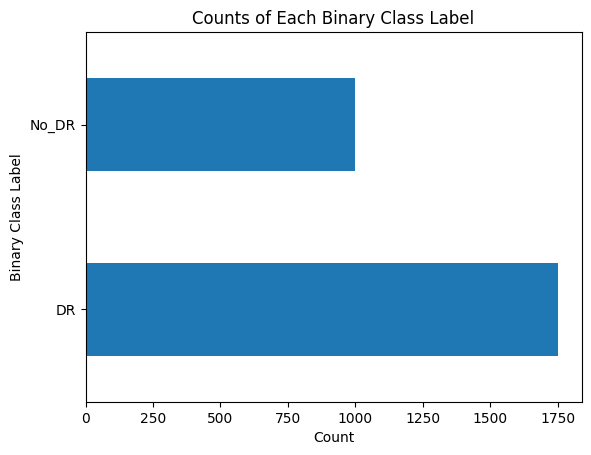

In [22]:
# Define binary diagnosis mapping dictionary
binary_diagnosis_dict = {
    'Healthy': 'No_DR',
    'Mild DR': 'DR',
    'Moderate DR': 'DR',
    'Severe DR': 'DR',
    'Proliferate DR': 'DR',
}

# Add the 'binary_type' column based on the 'class_label' column
df['binary_type'] = df['class_label'].map(binary_diagnosis_dict)

# Plot the counts of each binary class label
df['binary_type'].value_counts().plot(kind='barh')

# Set plot labels and title
plt.xlabel('Count')
plt.ylabel('Binary Class Label')
plt.title('Counts of Each Binary Class Label')

# Show the plot
plt.show()

In [23]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size=0.15, stratify=df['type'], random_state=42)
train, test = train_test_split(train_intermediate, test_size=0.15 / (1 - 0.15), stratify=train_intermediate['type'], random_state=42)

# Print class distribution in train, test, and val sets
print("Train set class distribution:\n", train['type'].value_counts(), '\n')
print("Test set class distribution:\n", test['type'].value_counts(), '\n')
print("Validation set class distribution:\n", val['type'].value_counts(), '\n')

Train set class distribution:
 type
0    700
2    630
1    258
4    203
3    133
Name: count, dtype: int64 

Test set class distribution:
 type
0    150
2    135
1     56
4     43
3     29
Name: count, dtype: int64 

Validation set class distribution:
 type
0    150
2    135
1     56
4     44
3     28
Name: count, dtype: int64 



In [24]:
# Path to the base directory
base_dir = '/kaggle/working'

# Create directories for train, val, and test sets
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create the directories if they don't exist
for directory in [train_dir, val_dir, test_dir]:
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

# Copy images to their respective directories
for index, row in train.iterrows():
    shutil.copy(row['image_path'], os.path.join(train_dir, row['type']))

for index, row in val.iterrows():
    shutil.copy(row['image_path'], os.path.join(val_dir, row['type']))

for index, row in test.iterrows():
    shutil.copy(row['image_path'], os.path.join(test_dir, row['type']))

In [25]:
# Define the source directory containing the images
src_dir = r'/kaggle/input/diabetic-retinopathy-dataset'

# Copy images to the respective working directory
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    image_filename = os.path.basename(row['image_path'])  # Get the filename from the image path
    folder_name = os.path.dirname(row['image_path']).split('/')[-1]  # Extract the folder name from the image path
    srcfile = os.path.join(src_dir, folder_name, image_filename)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    image_filename = os.path.basename(row['image_path'])  # Get the filename from the image path
    folder_name = os.path.dirname(row['image_path']).split('/')[-1]  # Extract the folder name from the image path
    srcfile = os.path.join(src_dir, folder_name, image_filename)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    image_filename = os.path.basename(row['image_path'])  # Get the filename from the image path
    folder_name = os.path.dirname(row['image_path']).split('/')[-1]  # Extract the folder name from the image path
    srcfile = os.path.join(src_dir, folder_name, image_filename)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    shutil.copy(srcfile, dstfile)

In [26]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 1924 images belonging to 2 classes.
Found 413 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 583ms/step - acc: 0.7898 - loss: 0.5564 - val_acc: 0.6368 - val_loss: 0.6551
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 36s 575ms/step - acc: 0.8878 - loss: 0.3424 - val_acc: 0.6368 - val_loss: 0.6804
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 573ms/step - acc: 0.9154 - loss: 0.2391 - val_acc: 0.6368 - val_loss: 0.7421
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 36s 576ms/step - acc: 0.9213 - loss: 0.2347 - val_acc: 0.6368 - val_loss: 0.7465
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 36s 577ms/step - acc: 0.9266 - loss: 0.2347 - val_acc: 0.6368 - val_loss: 0.7959
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 575ms/step - acc: 0.9377 - loss: 0.1804 - val_acc: 0.6368 - val_loss: 0.7097
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 36s 574ms/step - acc: 0.9376 - loss: 0.1878 - val_acc: 0.6513 - val_loss: 0.6333
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 36s 570ms/step - acc: 0.9469 - loss: 0.1543 - val_acc: 0.7433 - val_loss: 0.4414
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 567ms/step - acc:

In [26]:
loss, accuracy = model.evaluate(test_batches, verbose=1)
print("Loss:", loss)
print("Accuracy:", accuracy)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - acc: 0.9351 - loss: 0.1809
Loss: 0.1597364991903305
Accuracy: 0.9443099498748779


In [24]:
model.save('64x3-CNN.h5')

In [25]:
tf.saved_model.save(model, '64x3-CNN')

In [31]:
model.save("64x3-CNN.h5")

In [32]:
def predict_class(path):
    img = cv2.imread(path)
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (224, 224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("64x3-CNN.h5")
    predict = new_model.predict(np.array([image]))
    prediction = np.argmax(predict, axis=1)
    if prediction == 1:
        return 'No DR'
    else:
        return 'DR'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


'No DR'

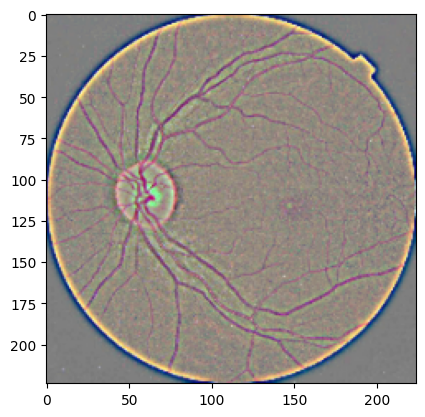

In [33]:
predict_class('/kaggle/input/diabetic-retinopathy-dataset/Healthy/Healthy.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


'DR'

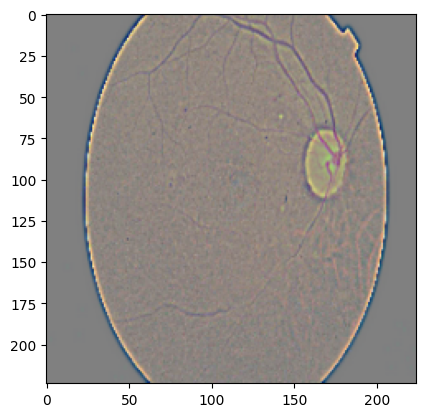

In [34]:
predict_class('/kaggle/input/diabetic-retinopathy-dataset/Mild DR/Mild_DR_100.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


'DR'

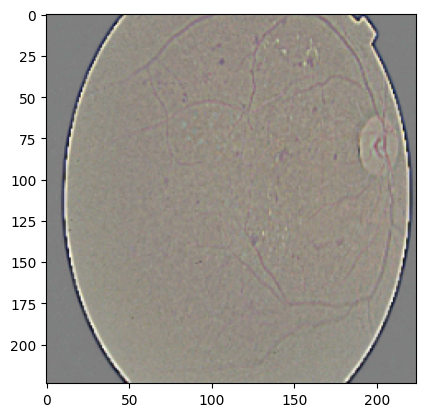

In [35]:
predict_class('/kaggle/input/diabetic-retinopathy-dataset/Moderate DR/Moderate_DR_102.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


'DR'

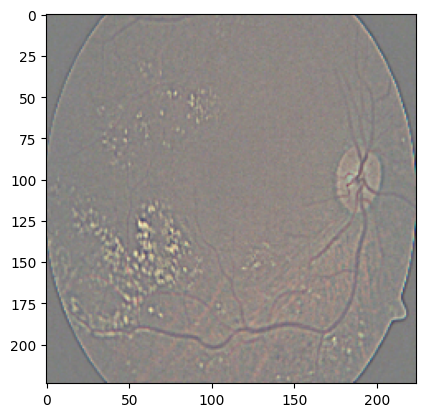

In [36]:
predict_class('/kaggle/input/diabetic-retinopathy-dataset/Proliferate DR/Proliferate DR_102.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


'DR'

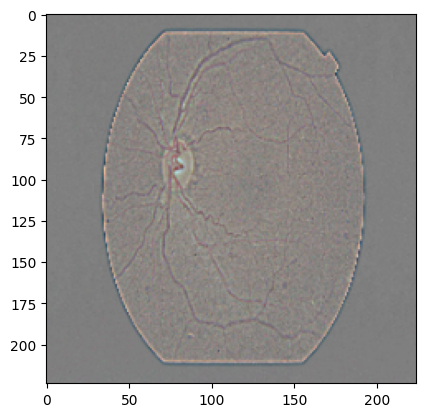

In [38]:
predict_class('/kaggle/input/diabetic-retinopathy-dataset/Severe DR/Severe DR_103.png')